# Capstone Project
## Image classifier for the SVHN dataset
### Instructions

In this notebook, you will create a neural network that classifies real-world images digits. You will use concepts from throughout this course in building, training, testing, validating and saving your Tensorflow classifier model.

This project is peer-assessed. Within this notebook you will find instructions in each section for how to complete the project. Pay close attention to the instructions as the peer review will be carried out according to a grading rubric that checks key parts of the project instructions. Feel free to add extra cells into the notebook as required.

### How to submit

When you have completed the Capstone project notebook, you will submit a pdf of the notebook for peer review. First ensure that the notebook has been fully executed from beginning to end, and all of the cell outputs are visible. This is important, as the grading rubric depends on the reviewer being able to view the outputs of your notebook. Save the notebook as a pdf (File -> Download as -> PDF via LaTeX). You should then submit this pdf for review.

### Let's get started!

We'll start by running some imports, and loading the dataset. For this project you are free to make further imports throughout the notebook as you wish. 

In [1]:
import tensorflow as tf
from scipy.io import loadmat

2025-04-15 02:04:36.125827: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744682676.153779    3230 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744682676.165361    3230 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


![SVHN overview image](data/svhn_examples.jpg)
For the capstone project, you will use the [SVHN dataset](http://ufldl.stanford.edu/housenumbers/). This is an  image dataset of over 600,000 digit images in all, and is a harder dataset than MNIST as the numbers appear in the context of natural scene images. SVHN is obtained from house numbers in Google Street View images. 

* Y. Netzer, T. Wang, A. Coates, A. Bissacco, B. Wu and A. Y. Ng. "Reading Digits in Natural Images with Unsupervised Feature Learning". NIPS Workshop on Deep Learning and Unsupervised Feature Learning, 2011.

Your goal is to develop an end-to-end workflow for building, training, validating, evaluating and saving a neural network that classifies a real-world image into one of ten classes.

In [2]:
# Run this cell to load the dataset

train = loadmat('/kaggle/input/images-svhn/train_32x32.mat')
test = loadmat('/kaggle/input/images-svhn/test_32x32.mat')

Both `train` and `test` are dictionaries with keys `X` and `y` for the input images and labels respectively.

## 1. Inspect and preprocess the dataset
* Extract the training and testing images and labels separately from the train and test dictionaries loaded for you.
* Select a random sample of images and corresponding labels from the dataset (at least 10), and display them in a figure.
* Convert the training and test images to grayscale by taking the average across all colour channels for each pixel. _Hint: retain the channel dimension, which will now have size 1._
* Select a random sample of the grayscale images and corresponding labels from the dataset (at least 10), and display them in a figure.

In [3]:
train.keys()

dict_keys(['__header__', '__version__', '__globals__', 'X', 'y'])

In [4]:
print(train['X'][:1])
print('\n')
print(len(train['y']))
print('\n')
print(train['y'])

[[[[ 33  84  19 ...  92 190 216]
   [ 30  76  54 ...  78 188 217]
   [ 38  59 110 ... 101 191 212]]

  [[ 15  86  20 ...  94 205 221]
   [ 23  73  52 ...  82 203 222]
   [ 19  66 111 ... 105 206 217]]

  [[ 15  77  25 ... 114 220 226]
   [ 17  78  57 ... 101 218 227]
   [ 19  56 116 ... 125 220 221]]

  ...

  [[ 72  90  65 ... 200 229 200]
   [ 65  78 144 ... 201 231 199]
   [ 56  69 223 ... 203 224 191]]

  [[ 82  88  78 ... 192 229 193]
   [ 77  77 148 ... 193 229 188]
   [ 57  67 218 ... 195 224 182]]

  [[ 89  88  98 ... 190 229 197]
   [ 79  78 158 ... 191 228 189]
   [ 59  66 220 ... 193 223 186]]]]


73257


[[1]
 [9]
 [2]
 ...
 [1]
 [6]
 [9]]


In [5]:
X_train, y_train, X_test, y_test = train['X'], train['y'], test['X'], test['y']

In [6]:
print(f"Shape of X_train:{X_train.shape}.\t Shape of y_train{y_train.shape}")
print(f"Shape of X_test:{X_test.shape}.\t Shape of y_test{y_test.shape}")

Shape of X_train:(32, 32, 3, 73257).	 Shape of y_train(73257, 1)
Shape of X_test:(32, 32, 3, 26032).	 Shape of y_test(26032, 1)


In [7]:
import numpy as np
unique_labels = np.unique(y_train.flatten())
unique_labels

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=uint8)

In [8]:
'''Old Axis Order	New Axis Order
0: height	1
1: width	2
2: channels	3
3: samples	0
Transpose images to (num_samples, 32, 32, 3)'''

X_train = X_train.transpose((3, 0, 1, 2))  # (73257, 32, 32, 3)
X_test = X_test.transpose((3, 0, 1, 2))    # (26032, 32, 32, 3)

# Flatten labels to 1D arrays
y_train = y_train.flatten()
y_test = y_test.flatten()

# Fix label '10' → '0' (SVHN-specific)
y_train[y_train == 10] = 0
y_test[y_test == 10] = 0

In [9]:
X_train.shape, X_test.shape

((73257, 32, 32, 3), (26032, 32, 32, 3))

In [10]:
print(y_train[:10])
print(y_test[:10])
print(f"Shape of y_train{y_train.shape}")
print(f"Shape of y_test{y_test.shape}")

[1 9 2 3 2 5 9 3 3 1]
[5 2 1 0 6 1 9 1 1 8]
Shape of y_train(73257,)
Shape of y_test(26032,)


In [11]:
import numpy as np
import matplotlib.pyplot as plt

def display_random_images(X_data, y_data, num_samples=10, grayscale=False):
    """
    Function to display random samples of images with their corresponding labels.
    
    Parameters:
    - X_data: Input image data (either color or grayscale).
    - y_data: Labels corresponding to the images.
    - num_samples: Number of random samples to display.
    - grayscale: Flag indicating if the images should be displayed in grayscale (True/False).
    """
    
    # Select at least num_samples random indices
    indices = np.random.choice(X_data.shape[0], num_samples, replace=False)

    # Create a figure to display the images
    plt.figure(figsize=(15, 5))

    # Loop over the selected indices and display each image with its label
    for i, idx in enumerate(indices):
        plt.subplot(2, 5, i + 1)  # Arrange images in a 2x5 grid
        
        if grayscale:
            # If grayscale, reshape the image (remove the channel dimension)
            plt.imshow(X_data[idx].reshape(32, 32), cmap='gray')
        else:
            # If color, display the color image directly
            plt.imshow(X_data[idx].reshape(32, 32, 3))  # Ensure the image has 3 channels
        
        plt.title(f"Label: {y_data[idx]}")  # Display the label
        plt.axis('off')  # Turn off axis labels

    plt.show()


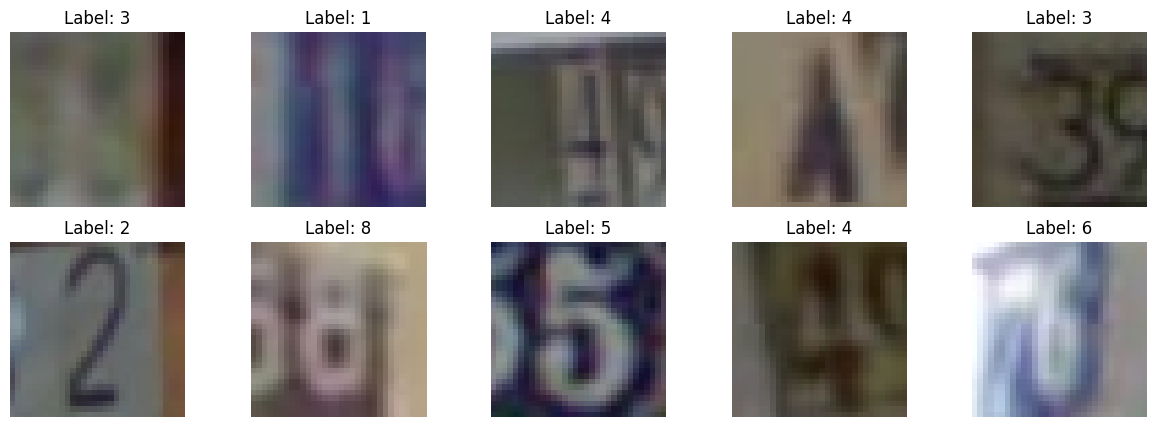

In [12]:
# Display random images
display_random_images(X_data=X_train, y_data=y_train, num_samples=10)

In [13]:
# Converting train and test images into grayscale
# Convert training and test images to grayscale by averaging across the 3 color channels
X_train_gray = np.mean(X_train, axis=-1, keepdims=True)
X_test_gray = np.mean(X_test, axis=-1, keepdims=True)

# Check the shape to ensure the channel dimension is retained (should be (N, 32, 32, 1))
print(f"X_train_gray shape: {X_train_gray.shape}")
print(f"X_test_gray shape: {X_test_gray.shape}")

X_train_gray shape: (73257, 32, 32, 1)
X_test_gray shape: (26032, 32, 32, 1)


In [14]:
X_train_gray[0].shape, X_test_gray[0].shape

((32, 32, 1), (32, 32, 1))

In [15]:
type(X_train_gray), type(X_test_gray), type(y_train), type(y_test)

(numpy.ndarray, numpy.ndarray, numpy.ndarray, numpy.ndarray)

In [16]:
print(f"X_train_gray shape: {X_train_gray.shape}, y_train shape:{y_train.shape}")
print("\n")
print(f"X_test_gray shape: {X_test_gray.shape}, y_test shape:{y_test.shape}")

X_train_gray shape: (73257, 32, 32, 1), y_train shape:(73257,)


X_test_gray shape: (26032, 32, 32, 1), y_test shape:(26032,)


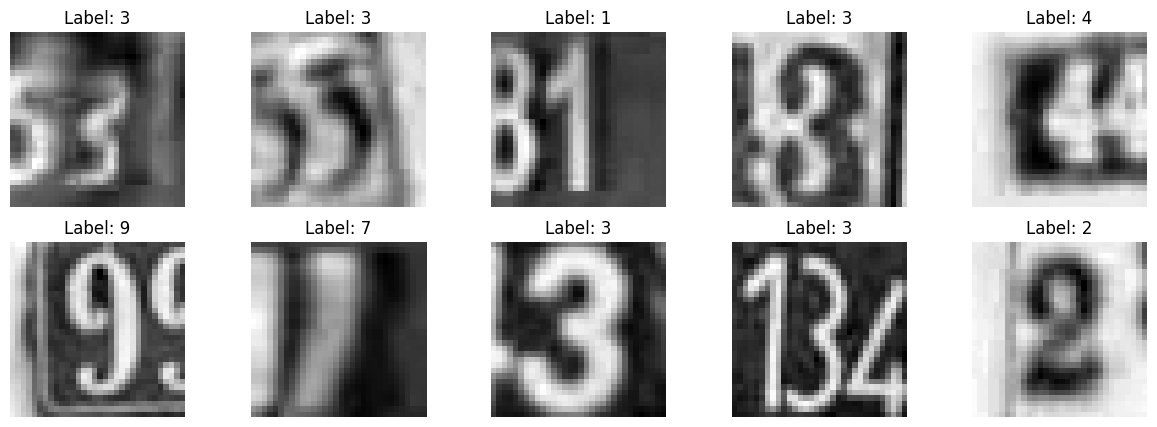

In [17]:
# Display random grayscale images
display_random_images(X_data=X_train_gray, y_data=y_train, num_samples=10, grayscale=True)

In [18]:
# One-hot-encoding the labels
from tensorflow.keras.utils import to_categorical
y_train_one_hot = to_categorical(y_train, num_classes=10)
y_test_one_hot = to_categorical(y_test, num_classes=10)

In [19]:
X_train_gray_normalized = X_train_gray / 255.0
X_test_gray_normalized = X_test_gray / 255.0

## 2. MLP neural network classifier
* Build an MLP classifier model using the Sequential API. Your model should use only Flatten and Dense layers, with the final layer having a 10-way softmax output. 
* You should design and build the model yourself. Feel free to experiment with different MLP architectures. _Hint: to achieve a reasonable accuracy you won't need to use more than 4 or 5 layers._
* Print out the model summary (using the summary() method)
* Compile and train the model (we recommend a maximum of 30 epochs), making use of both training and validation sets during the training run. 
* Your model should track at least one appropriate metric, and use at least two callbacks during training, one of which should be a ModelCheckpoint callback.
* As a guide, you should aim to achieve a final categorical cross entropy training loss of less than 1.0 (the validation loss might be higher).
* Plot the learning curves for loss vs epoch and accuracy vs epoch for both training and validation sets.
* Compute and display the loss and accuracy of the trained model on the test set.

In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [21]:
# Create callbacks for the MLP model

def get_checkpoint_best_only_mlp():
    """
    This function should return a ModelCheckpoint object that:
    - saves only the weights that generate the highest validation (testing) accuracy
    - saves into a directory called 'checkpoints_best_only' inside the current working directory
    - generates a file called 'checkpoints_best_only/checkpoint'
    """
    import os
    os.makedirs('checkpoints_best_only_mlp', exist_ok=True)
    checkpoint_path = 'checkpoints_best_only_mlp/checkpoint.weights.h5'
    checkpoint_best_only = ModelCheckpoint(filepath=checkpoint_path,
                                          save_weights_only=True,
                                          save_best_only=True,
                                          monitor='val_accuracy',
                                          mode='max',
                                          verbose=1)
    return checkpoint_best_only

In [22]:
def get_early_stopping():
    """
    This function should return an EarlyStopping callback that stops training when
    the validation (testing) accuracy has not improved in the last 6 epochs.
    HINT: use the EarlyStopping callback with the correct 'monitor' and 'patience'
    """
    early_stopping = EarlyStopping(monitor='val_accuracy',
                                  patience=6,
                                  mode='max',
                                  verbose=1)
    return early_stopping

In [23]:
checkpoint_best_only_mlp = get_checkpoint_best_only_mlp()
early_stopping = get_early_stopping()
callbacks = [checkpoint_best_only_mlp, early_stopping]

In [28]:
def get_new_model(input_shape):

    model = Sequential([
        Flatten(input_shape=input_shape, name='flatten_layer'),
        Dense(1024, activation='relu', name='dense_layer_1'),
        Dense(128, activation='relu', name='dense_layer_2'),
        Dense(10, activation='softmax', name='output_layer_final_layer')])

    model.compile(optimizer='adam',
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])

    return model

In [29]:
model_mlp = get_new_model(input_shape=X_test_gray[0].shape)

In [30]:
model_mlp.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten_layer (Flatten)              │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_layer_1 (Dense)                │ (None, 1024)                │       1,049,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_layer_2 (Dense)                │ (None, 128)                 │         131,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output_layer_final_layer (Dense)     │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,182,090 (4.51 MB)

 Trainable params: 1,182,090 (4.51 MB)

 Non-trainable params: 0 (0.00 B)

In [31]:
history_mlp = model_mlp.fit(X_train_gray_normalized, y_train_one_hot,
                            validation_data=(X_test_gray_normalized, y_test_one_hot),
                            epochs=30,
                            batch_size=64,
                            verbose=2,
                            callbacks=callbacks)

Epoch 1/30

Epoch 1: val_accuracy improved from 0.21059 to 0.36240, saving model to checkpoints_best_only_mlp/checkpoint.weights.h5
1145/1145 - 7s - 6ms/step - accuracy: 0.2367 - loss: 2.1199 - val_accuracy: 0.3624 - val_loss: 1.8083
Epoch 2/30

Epoch 2: val_accuracy improved from 0.36240 to 0.57299, saving model to checkpoints_best_only_mlp/checkpoint.weights.h5
1145/1145 - 2s - 2ms/step - accuracy: 0.5048 - loss: 1.4774 - val_accuracy: 0.5730 - val_loss: 1.3398
Epoch 3/30

Epoch 3: val_accuracy improved from 0.57299 to 0.64540, saving model to checkpoints_best_only_mlp/checkpoint.weights.h5
1145/1145 - 2s - 2ms/step - accuracy: 0.6315 - loss: 1.1744 - val_accuracy: 0.6454 - val_loss: 1.1868
Epoch 4/30

Epoch 4: val_accuracy improved from 0.64540 to 0.66560, saving model to checkpoints_best_only_mlp/checkpoint.weights.h5
1145/1145 - 2s - 2ms/step - accuracy: 0.6722 - loss: 1.0670 - val_accuracy: 0.6656 - val_loss: 1.1257
Epoch 5/30

Epoch 5: val_accuracy improved from 0.66560 to 0.688

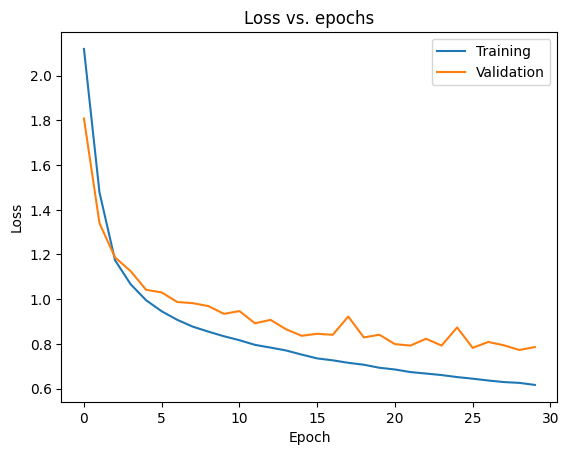

In [32]:
import matplotlib.pyplot as plt

plt.plot(history_mlp.history['loss'])
plt.plot(history_mlp.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

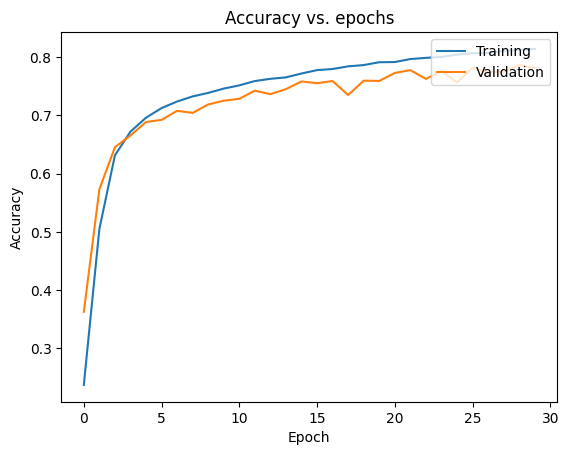

In [33]:
plt.plot(history_mlp.history['accuracy'])
plt.plot(history_mlp.history['val_accuracy'])
plt.title('Accuracy vs. epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

In [36]:
test_loss, test_accuracy  = model_mlp.evaluate(X_test_gray_normalized, y_test_one_hot, verbose=0)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

Test Loss: 0.7857, Test Accuracy: 0.7818


## 3. CNN neural network classifier
* Build a CNN classifier model using the Sequential API. Your model should use the Conv2D, MaxPool2D, BatchNormalization, Flatten, Dense and Dropout layers. The final layer should again have a 10-way softmax output. 
* You should design and build the model yourself. Feel free to experiment with different CNN architectures. _Hint: to achieve a reasonable accuracy you won't need to use more than 2 or 3 convolutional layers and 2 fully connected layers.)_
* The CNN model should use fewer trainable parameters than your MLP model.
* Compile and train the model (we recommend a maximum of 30 epochs), making use of both training and validation sets during the training run.
* Your model should track at least one appropriate metric, and use at least two callbacks during training, one of which should be a ModelCheckpoint callback.
* You should aim to beat the MLP model performance with fewer parameters!
* Plot the learning curves for loss vs epoch and accuracy vs epoch for both training and validation sets.
* Compute and display the loss and accuracy of the trained model on the test set.

In [60]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dropout
from tensorflow.keras import regularizers

In [38]:
def get_checkpoint_best_only_cnn():
    """
    This function should return a ModelCheckpoint object that:
    - saves only the weights that generate the highest validation (testing) accuracy
    - saves into a directory called 'checkpoints_best_only' inside the current working directory
    - generates a file called 'checkpoints_best_only/checkpoint'
    """
    import os
    os.makedirs('checkpoints_best_only_cnn', exist_ok=True)
    checkpoint_path = 'checkpoints_best_only_cnn/checkpoint_cnn.weights.h5'
    checkpoint_best_only = ModelCheckpoint(filepath=checkpoint_path,
                                          save_weights_only=True,
                                          save_best_only=True,
                                          monitor='val_accuracy',
                                          mode='max',
                                          verbose=1)
    return checkpoint_best_only

In [145]:
def get_early_stopping_cnn():
    """
    This function should return an EarlyStopping callback that stops training when
    the validation (testing) accuracy has not improved in the last 6 epochs.
    HINT: use the EarlyStopping callback with the correct 'monitor' and 'patience'
    """
    early_stopping_cnn = EarlyStopping(monitor='val_loss',
                                  patience=8,
                                  mode='min',
                                  restore_best_weights=True,
                                  verbose=1)
    return early_stopping_cnn

In [146]:
checkpoint_best_only_cnn = get_checkpoint_best_only_cnn()
early_stopping_cnn = get_early_stopping_cnn()
callbacks_cnn = [checkpoint_best_only_cnn, early_stopping_cnn]

In [147]:
def get_cnn_model(input_shape):
    model = Sequential([
        Conv2D(32, (3, 3),input_shape=input_shape, kernel_regularizer=regularizers.l2(0.001) ,activation='relu', padding='same', name='conv_layer_1'),
        MaxPooling2D((2,2), name='max_pool_layer_1'),
        BatchNormalization(name='batch_norm_layer_1'),
        Conv2D(32, (3, 3), kernel_regularizer=regularizers.l2(0.001), activation='relu', padding='same', name='conv_layer_2'),
        Flatten(name='flatten_layer'),
        Dense(64, activation='relu', name='dense_layer_1'),
        Dropout(0.3, name='dropout_layer_1'),
        Dense(10, activation='softmax', name='output_layer_final_layer')])

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                loss='categorical_crossentropy',
                metrics=['accuracy'])

    return model

In [148]:
model_cnn = get_cnn_model(input_shape=X_test_gray[0].shape)

In [149]:
model_cnn.summary()

Model: "sequential_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv_layer_1 (Conv2D)                │ (None, 32, 32, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pool_layer_1 (MaxPooling2D)      │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_norm_layer_1                   │ (None, 16, 16, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_layer_2 (Conv2D)                │ (None, 16, 16, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_layer (Flatten)              │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_layer_1 (Dense)                │ (None, 64)                  │         524,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_layer_1 (Dropout)            │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output_layer_final_layer (Dense)     │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 534,698 (2.04 MB)

 Trainable params: 534,634 (2.04 MB)

 Non-trainable params: 64 (256.00 B)

In [150]:
history_cnn = model_cnn.fit(X_train_gray_normalized, y_train_one_hot,
                            validation_data=(X_test_gray_normalized, y_test_one_hot),
                            epochs=30,
                            batch_size=32,
                            verbose=2,
                            callbacks=callbacks_cnn)

Epoch 1/30

Epoch 1: val_accuracy improved from -inf to 0.80724, saving model to checkpoints_best_only_cnn/checkpoint_cnn.weights.h5
2290/2290 - 13s - 6ms/step - accuracy: 0.5939 - loss: 1.2740 - val_accuracy: 0.8072 - val_loss: 0.7049
Epoch 2/30

Epoch 2: val_accuracy improved from 0.80724 to 0.83274, saving model to checkpoints_best_only_cnn/checkpoint_cnn.weights.h5
2290/2290 - 6s - 3ms/step - accuracy: 0.7887 - loss: 0.7257 - val_accuracy: 0.8327 - val_loss: 0.6092
Epoch 3/30

Epoch 3: val_accuracy did not improve from 0.83274
2290/2290 - 6s - 3ms/step - accuracy: 0.8240 - loss: 0.6145 - val_accuracy: 0.8293 - val_loss: 0.6015
Epoch 4/30

Epoch 4: val_accuracy improved from 0.83274 to 0.84365, saving model to checkpoints_best_only_cnn/checkpoint_cnn.weights.h5
2290/2290 - 6s - 3ms/step - accuracy: 0.8400 - loss: 0.5574 - val_accuracy: 0.8437 - val_loss: 0.5645
Epoch 5/30

Epoch 5: val_accuracy improved from 0.84365 to 0.85814, saving model to checkpoints_best_only_cnn/checkpoint_cn

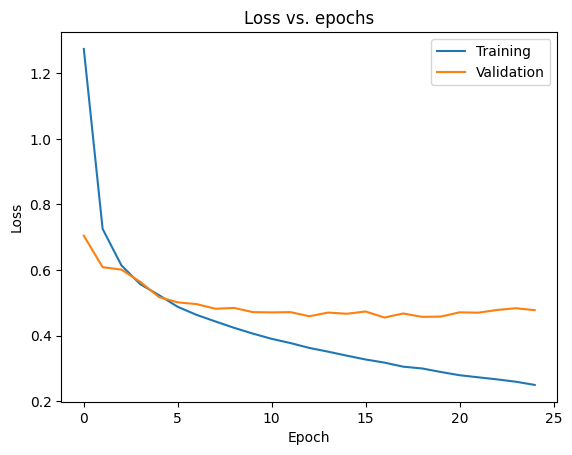

In [151]:
plt.plot(history_cnn.history['loss'])
plt.plot(history_cnn.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

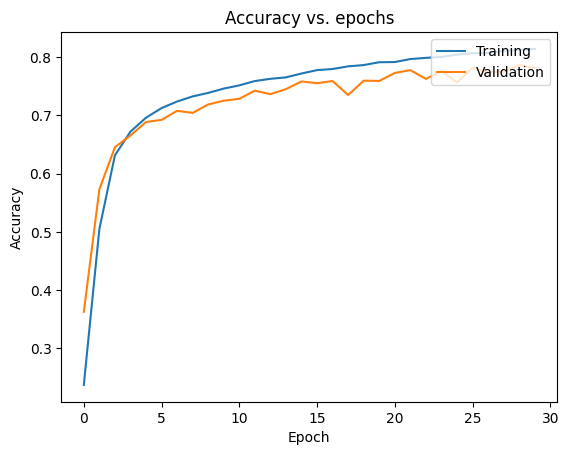

In [152]:
plt.plot(history_mlp.history['accuracy'])
plt.plot(history_mlp.history['val_accuracy'])
plt.title('Accuracy vs. epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

In [153]:
test_loss_cnn, test_accuracy_cnn  = model_cnn.evaluate(X_test_gray_normalized, y_test_one_hot, verbose=0)
print(f"Test Loss: {test_loss_cnn:.4f}, Test Accuracy: {test_accuracy_cnn:.4f}")

Test Loss: 0.4556, Test Accuracy: 0.8803


In [164]:
# Check whether the CNN model performs better than the MLP model with fewer parameters
if model_cnn.count_params() < model_mlp.count_params():
    if test_loss_cnn < test_loss and test_accuracy_cnn > test_accuracy:
        print("CNN outperformed the MLP with fewer parameters")

CNN outperformed the MLP with fewer parameters


* Load the best weights for the MLP and CNN models that you saved during the training run.
* Randomly select 5 images and corresponding labels from the test set and display the images with their labels.
* Alongside the image and label, show each model’s predictive distribution as a bar chart, and the final model prediction given by the label with maximum probability.

In [165]:
mlp_weights_path = '/kaggle/working/checkpoints_best_only_mlp/checkpoint.weights.h5'
cnn_weights_path = '/kaggle/working/checkpoints_best_only_cnn/checkpoint_cnn.weights.h5'

In [166]:
mlp_model = get_new_model(input_shape=X_train_gray[0].shape)
cnn_model = get_cnn_model(input_shape=X_train_gray[0].shape)

In [167]:
mlp_model.load_weights(mlp_weights_path)
cnn_model.load_weights(cnn_weights_path)

In [168]:
import random
import matplotlib.pyplot as plt

In [169]:
# Generate random indices
indices = np.random.choice(len(X_test_gray), 5, replace=False)

# Get the images and labels
selected_images = X_test_gray[indices]
selected_labels = y_test[indices]

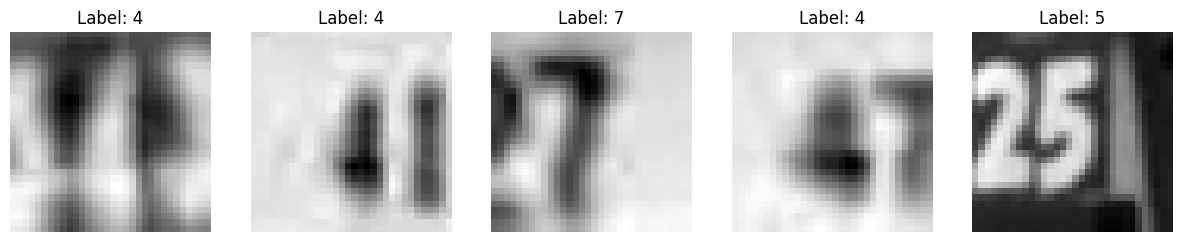

In [170]:
# Plot the images with their labels
fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for i, ax in enumerate(axes):
    ax.imshow(selected_images[i], cmap='gray')  # Adjust for your image format
    ax.set_title(f"Label: {selected_labels[i]}")
    ax.axis('off')
plt.show()

In [171]:
# Get model predictions
mlp_preds = mlp_model.predict(selected_images)
cnn_preds = cnn_model.predict(selected_images)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step


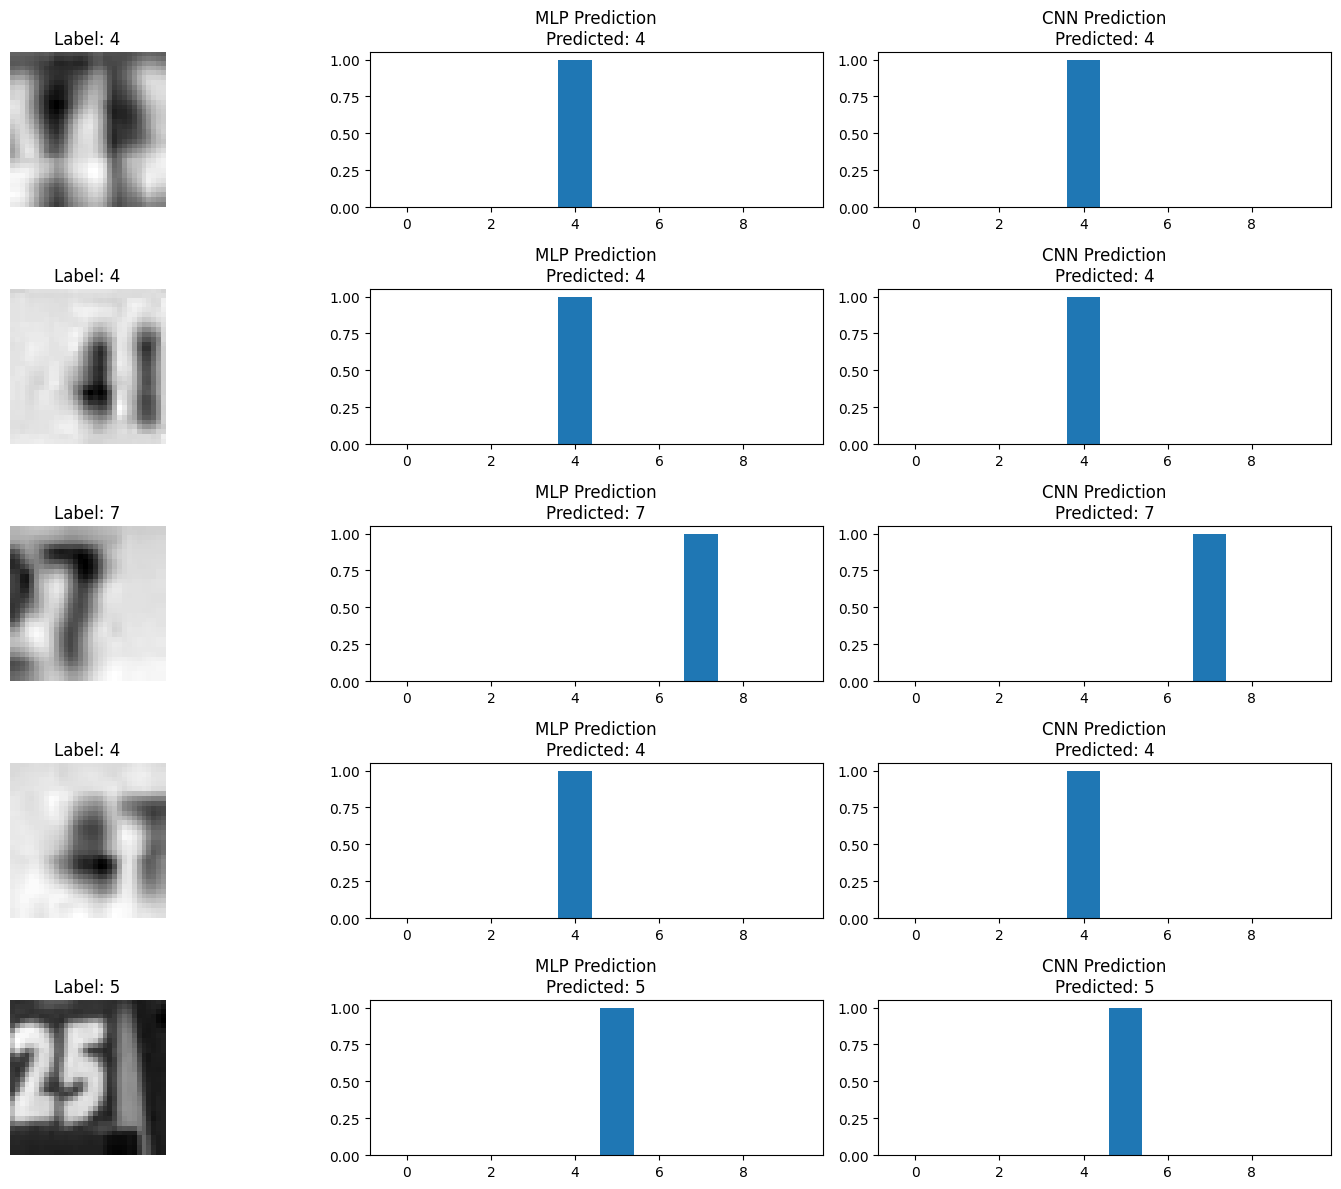

In [172]:
fig, axes = plt.subplots(5, 3, figsize=(15, 12))

for i in range(5):
    # Display image and label
    axes[i, 0].imshow(selected_images[i], cmap='gray')
    axes[i, 0].set_title(f"Label: {selected_labels[i]}")
    axes[i, 0].axis('off')

    # Plot MLP prediction distribution
    axes[i, 1].bar(range(len(mlp_preds[i])), mlp_preds[i])
    axes[i, 1].set_title(f"MLP Prediction\nPredicted: {np.argmax(mlp_preds[i])}")

    # Plot CNN prediction distribution
    axes[i, 2].bar(range(len(cnn_preds[i])), cnn_preds[i])
    axes[i, 2].set_title(f"CNN Prediction\nPredicted: {np.argmax(cnn_preds[i])}")

plt.tight_layout()
plt.show()
